In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Your agent's name here
model_name = "jimmy"

# The epochs you want to sample from
levels = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# The name of the board-variant here
full_name = "8x8standard"
dims = (8, 8)

# The concepts to make graphs out ofs
concepts = ["material_advantage"]

In [26]:
import tensorflow as tf
from minichess.agents.lite_model import LiteModel
from minichess.agents.predictor_convnet import PredictorConvNet

def load_model(full_name, model_name, epoch):
    keras_model = tf.keras.models.load_model("minichess/agents/checkpoints/{}/{}/{}".format(full_name, model_name, epoch))
    simple_model = PredictorConvNet(LiteModel.from_keras_model(keras_model))
    del keras_model
    return simple_model

agents = [load_model(full_name, model_name, epoch) for epoch in levels]

INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpprepxhxt\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpprepxhxt\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmppxu99idw\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmppxu99idw\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpw6o6ek_u\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpw6o6ek_u\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmp11btj3q6\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmp11btj3q6\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpfsn1tyqf\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpfsn1tyqf\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpcxlgg9gb\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpcxlgg9gb\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmp09prp5je\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmp09prp5je\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpco1yyr59\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpco1yyr59\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpsp69ai6y\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpsp69ai6y\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpp6iyju71\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpp6iyju71\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpjwuj4ekq\assets


INFO:tensorflow:Assets written to: C:\Users\Rares\AppData\Local\Temp\tmpjwuj4ekq\assets


In [27]:
from scipy.stats import norm
import numpy as np
import tensorflow as tf
from minichess.chess.fastchess_utils import piece_matrix_to_legal_moves
from minichess.chess.move_utils import move_to_index, index_to_move
from minichess.rl.chess_helpers import get_initial_chess_object
from itertools import combinations

def calculate_elo_update(rating_a, rating_b, result, k=32):
    expected_a = 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    rating_a_new = rating_a + k * (result - expected_a)
    rating_b_new = rating_b + k * ((1 - result) - (1 - expected_a))
    return rating_a_new, rating_b_new

def play_match_and_calculate_elo(agents, full_name, dims, move_cap, all_moves, all_moves_inv, elo_ratings, k=32):
    chess = get_initial_chess_object(full_name)
    to_start = 1 if np.random.random() > 0.5 else 0
    current = to_start

    while chess.game_result() is None:
        agent_to_play = agents[current]
        dist, value = agent_to_play.predict(chess.agent_board_state())

        moves, proms = chess.legal_moves()
        legal_moves = piece_matrix_to_legal_moves(moves, proms)
        legal_moves_mask = np.zeros((dims[0], dims[1], all_moves_inv.shape[0]))
        for move in legal_moves:
            (i, j), (dx, dy), promotion = move
            ind = move_to_index(all_moves, dx, dy, promotion, chess.turn)
            legal_moves_mask[i, j, ind] = 1

        move_dims = dist.shape

        dist = (dist + 0.5 * np.random.uniform(size=dist.shape)) * legal_moves_mask.flatten()
        dist /= dist.sum()
        move_to_play = np.argmax(dist)

        i, j, ind = np.unravel_index(move_to_play, (dims[0], dims[1], move_cap))
        dx, dy, promotion = index_to_move(all_moves_inv, ind, chess.turn)
        chess.make_move(i, j, dx, dy, promotion)
        current = (current + 1) % 2

    result = chess.game_result()
    if result == 1:  # White wins
        result_for_elo = 1 if to_start == 0 else 0
        #print("WIN", end=" ")
    elif result == 2:  # Black wins
        result_for_elo = 0 if to_start == 0 else 1
        #print("LOSE", end=" ")
    else:
        result_for_elo = 0.5
        #print("EQUAL", end=" ")

    elo_ratings[0], elo_ratings[1] = calculate_elo_update(
        elo_ratings[0], elo_ratings[1], result_for_elo, k=k
    )

    return elo_ratings

def simulate_round_robin_tournament(
    agents, full_name, dims, move_cap, all_moves, all_moves_inv, num_games_per_pair=3, initial_elo=1500, max_k=64, min_k=16
):
    # ELO ratings initialization
    num_agents = len(agents)
    elo_ratings = {i: initial_elo for i in range(num_agents)}

    # All combinations of matches
    pairings = list(combinations(range(num_agents), 2))

    # Match simulation for each pair
    for agent1_id, agent2_id in pairings:
        #print(f"Playing matches between Agent {agent1_id} and Agent {agent2_id}")

        for game in range(num_games_per_pair):
            # Dynamically adjusted K-factor
            k = max_k - (game * (max_k - min_k) / (num_games_per_pair - 1)) if num_games_per_pair > 1 else max_k

            # Match simulation
            elo_ratings[agent1_id], elo_ratings[agent2_id] = play_match_and_calculate_elo(
                [agents[agent1_id], agents[agent2_id]],
                full_name,
                dims,
                move_cap,
                all_moves,
                all_moves_inv,
                [elo_ratings[agent1_id], elo_ratings[agent2_id]],
                k=k
            )

            '''print(
                f"Game {game + 1} (K={k:.2f}) between Agent {agent1_id} and Agent {agent2_id}: "
                f"Agent {agent1_id} ELO = {elo_ratings[agent1_id]:.2f}, "
                f"Agent {agent2_id} ELO = {elo_ratings[agent2_id]:.2f}"
            )'''

    return elo_ratings

In [ ]:
from minichess.chess.move_utils import calculate_all_moves

all_moves, all_moves_inv = calculate_all_moves(dims)
move_cap = all_moves_inv.shape[0]

# Run the round-robin tournament
final_elo = simulate_round_robin_tournament(
    agents, full_name, dims, move_cap, all_moves, all_moves_inv, num_games_per_pair=200, initial_elo=1500, max_k=1000, min_k=40
)

print("Final ELO Ratings:")
for agent_id, elo in sorted(final_elo.items(), key=lambda x: -x[1]):
    print(f"Agent {agent_id}: {elo:.2f}")

c:\Users\Rares\Desktop\explainable-minichess\minichess\chess\fastchess.py:159: RuntimeWarning: overflow encountered in ulonglong_scalars
  magic = magic_table[i, j]
c:\Users\Rares\Desktop\explainable-minichess\minichess\chess\fastchess_utils.py:421: RuntimeWarning: overflow encountered in ulonglong_scalars
  return board & (board - B_1) != 0
c:\Users\Rares\Desktop\explainable-minichess\minichess\chess\fastchess.py:159: RuntimeWarning: overflow encountered in ulonglong_scalars
  magic = magic_table[i, j]
c:\Users\Rares\Desktop\explainable-minichess\minichess\chess\fastchess_utils.py:421: RuntimeWarning: overflow encountered in ulonglong_scalars
  return board & (board - B_1) != 0


In [25]:
final_elo

{0: 722.7407485641892,
 1: 792.6282826352299,
 2: 784.791538204685,
 3: 697.8936379601458,
 4: 707.4650742992925,
 5: 802.8516832228477,
 6: 787.8473043951496,
 7: 788.6436180528582,
 8: 849.7663325593658,
 9: 873.2377130053968,
 10: 863.4253775280429,
 11: 828.3883532248786,
 12: 850.1597886755,
 13: 850.1605476724154}

C:\Users\Rares\AppData\Local\Temp\ipykernel_22052\1097536335.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn-muted")


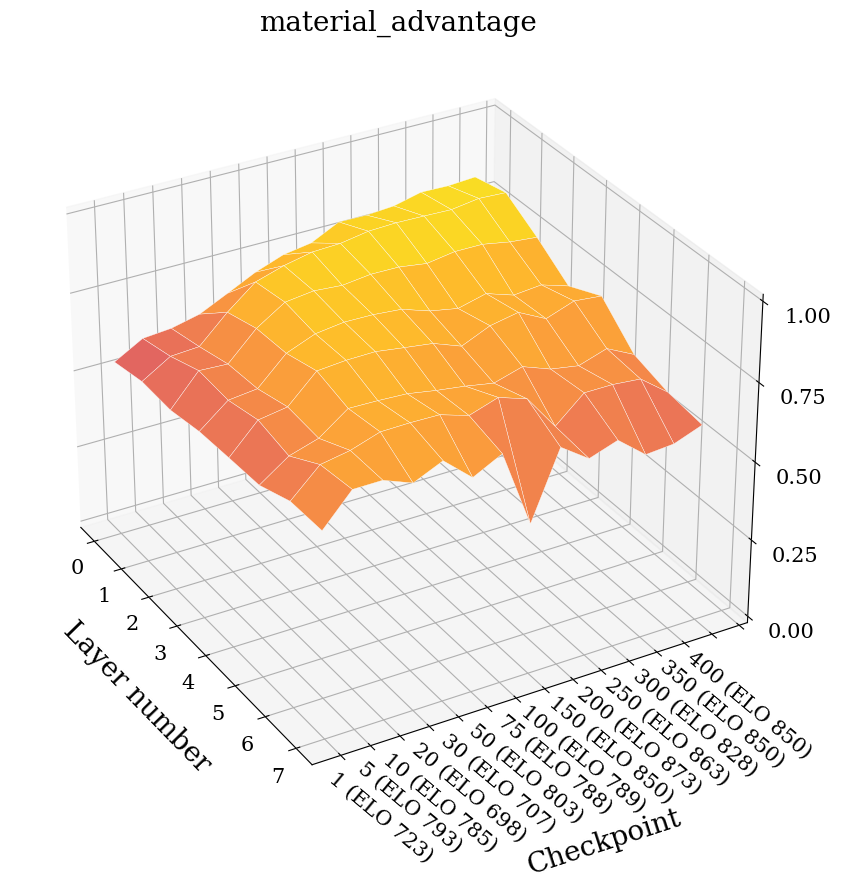

In [71]:
import os
import json
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

for concept in concepts:
    z = []

    for level in levels:
        presences = []
        for file in os.listdir("concept_presences/{}/{}/{}/{}".format(full_name, model_name, concept, level)):
            with open(os.path.join("concept_presences/{}/{}/{}/{}".format(full_name, model_name, concept, level), file)) as f:
                data = json.load(f)
                presences.append(data)

        y = []

        for (i, presence) in enumerate(presences):
            y = []
            for j, ind_presence in enumerate(presence):
                y.append(ind_presence)
            z.append(y)
    z = np.array(z)

    mpl.style.use("seaborn-muted")
    mpl.rcParams['figure.figsize'] = (10, 11)
    mpl.rcParams['lines.linewidth'] = 20.0

    mpl.rcParams['font.family'] = "serif"
    mpl.rcParams["axes.axisbelow"] = True
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(len(levels))
    Y = np.arange(z.shape[1])
    X, Y = np.meshgrid(Y, X)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, z, cmap=cm.plasma, edgecolor="white", linewidth=0.25, vmin=0.1, vmax=0.9)
    # Customize the z axis.
    ax.set_zlim(0, 1.00)
    ax.set_axisbelow(False)
    ax.set_title(concept, fontsize=20)
    ax.set_xlabel("Layer number", labelpad=15, fontsize=20, zorder=10)
    ax.set_ylabel("Checkpoint", labelpad=55,fontsize=20,zorder=10)
    plt.xticks(fontsize=15, rotation=0)
    plt.xticks(np.arange(z.shape[1]))
    plt.yticks(fontsize=15, rotation=-40)
    ax.tick_params('z', labelsize=15, pad=10, reset=True)
    fig.patch.set_facecolor("white")

    ax.zaxis.set_major_locator(LinearLocator(5))

    labels = [""] + [f"{level} (ELO {int(round(final_elo.get(idx, 0), 0))})" for idx, level in enumerate(levels)]
    plt.yticks(np.arange(len(labels)), labels)
    yticks = ax.yaxis.get_major_ticks()

    yticks[-1].label1.set_visible(True)
    # A StrMethodFormatter is used automatically
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.view_init(30, -30)

    os.makedirs("plots/{}/{}".format(full_name, model_name), exist_ok=True)
    plt.savefig("plots/{}/{}/{}.png".format(full_name, model_name, concept), transparent=False)